In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

In [2]:
#act_directory = "/Users/InsanallyLab/Desktop/Analysis_Cache"
#act_directory = 'D:\\Analysis_Cache'
act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache'

In [3]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 515/515 [00:06<00:00, 79.49it/s] 


In [4]:
sessionfile.meta.animal

'TH_237'

In [5]:
# FRmod_cohort1 = []
# FRmod_cohort2 = []
# FRmod_cohort3 = []

In [6]:
# for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
#     ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
#     #if ACsessionfile.meta.region != 'AC':   Already handled in enum creations
#     #    continue
    
#     if ACsessionfile.meta.animal in cohort1:
#         FRmod_cohort1.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        
#     if ACsessionfile.meta.animal in cohort2:
#         FRmod_cohort2.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        
#     if ACsessionfile.meta.animal in cohort3:
#         FRmod_cohort3.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)


In [7]:
# FRmod_cohort1 = np.array(FRmod_cohort1)
# FRmod_cohort2 = np.array(FRmod_cohort2)
# FRmod_cohort3 = np.array(FRmod_cohort3)

In [8]:
# #Firing rate modulation graphs

# size=5

# FRmod_baseline_median = 3.5938903863432152

# fig, ax = plt.subplots(figsize=(4,4.5))
# data = [FRmod_cohort1, FRmod_cohort2, FRmod_cohort3]
# labels = ['Cohort1','Cohort2','Cohort3']
# numCon = len(data)
# X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

# _,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
# X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
# colors = NCR_CR_cmap((Y-1)/5)

# ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
# ax.set_yscale('log',subsy=[])

# #Plot summary
# for idx,column in enumerate(data):
#     percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
#     eye_color=NCR_CR_cmap((percentCR-40)/20)
    
#     r,g,b = mpl.colors.to_rgb(eye_color)
#     h,l,s = colorsys.rgb_to_hls(r,g,b)
#     border_color=colorsys.hls_to_rgb(h,l*0.5,s)
#     print(border_color)

#     summary_size=50
#     summary_width=1
    
#     Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
#     ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
#     ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

# #
# ax.set_ylim([0.1,100])
# ax.set_yticks([0.1,1,10,100])
# ax.set_yticklabels(['0.1','1','10','100'])
# ax.set_ylabel('Firing rate modulation(spikes/s)')

# ax.set_xlim([-0.5,2.5])
# ax.set_xticks(range(numCon))
# ax.set_xticklabels(labels,fontsize=7.5)
# ax.set_xlim(ax.get_xlim())

# for idx,column in enumerate(data):
#     ax.text(idx,90,str(len(column)))

# ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
# ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
# #fig.savefig(os.path.join('D:\\\\Figures','Passive No Behavior Figures','Passive no behavior Shift FRmod over exposure.pdf'),transparent=False,facecolor="white")

In [9]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [10]:
preearly_animal = []
prelate_animal = []
preexpert_animal = []
postearly_animal = []
postlate_animal = []
postexpert_animal = []


for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        FRmod_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_animal.append(ACsessionfile.meta.animal)
        
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        FRmod_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        FRmod_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        FRmod_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        FRmod_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        FRmod_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_animal.append(ACsessionfile.meta.animal)
    

1442it [00:13, 110.43it/s]


In [11]:
#number of animals in each learning phase

preearly_animal = np.unique(preearly_animal)
prelate_animal = np.unique(prelate_animal)
preexpert_animal = np.unique(preexpert_animal)
postearly_animal = np.unique(postearly_animal)
postlate_animal = np.unique(postlate_animal)
postexpert_animal = np.unique(postexpert_animal)

preearly_animal_num = len(preearly_animal)
prelate_animal_num = len(prelate_animal)
preexpert_animal_num = len(preexpert_animal)
postearly_animal_num = len(postearly_animal)
postlate_animal_num = len(postlate_animal)
postexpert_animal_num = len(postexpert_animal)

In [12]:
preearly_animal

array(['TH_201', 'TH_203'], dtype='<U6')

In [13]:
prelate_animal

array(['TH_201', 'TH_203', 'TH_233', 'TH_234'], dtype='<U6')

In [14]:
preexpert_animal

array(['TH_201', 'TH_203', 'TH_233', 'TH_234'], dtype='<U6')

In [15]:
postearly_animal

array(['LA_204', 'LA_205'], dtype='<U6')

In [16]:
postlate_animal

array(['AE_229', 'LA_204', 'TH_200', 'TH_230'], dtype='<U6')

In [17]:
postexpert_animal

array(['AE_229', 'TH_200', 'TH_230'], dtype='<U6')

In [18]:
# preearly_animal: TH_201, TH_203
# prelate_animal: TH_201, TH_203
# preexpert_animal: TH_201, TH_203
# postearly_animal: LA_204, LA_205
# postlate_animal: AE_229, LA_204, TH_200, TH_230
# postexpert_animal: AE_229, TH_200, TH_230

In [19]:
FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

In [20]:
FRmod_baseline_median = np.median(FRmod_preearly)
print(FRmod_baseline_median)

2.6315789473684212


(0.42097718360607495, 0.19810071782476768, 0.20786173092467894)
(0.287481233672967, 0.24571078187198975, 0.2475401447245873)
(0.29417824746592147, 0.2442955204196111, 0.24648016539974144)
(0.2568044776498045, 0.2504380590044969, 0.25071688025903593)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)


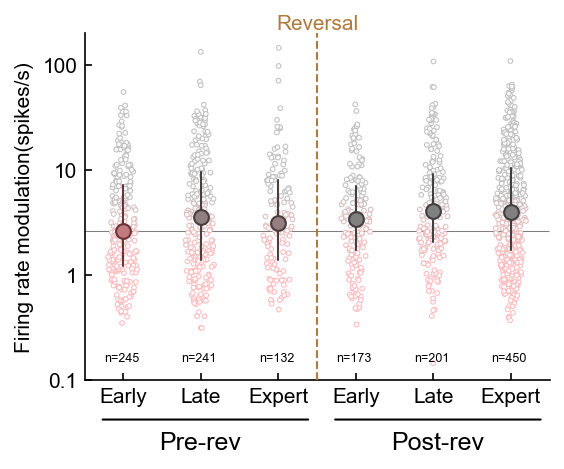

meta NOT subset; don't know how to subset; dropped


In [230]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.median(FRmod_preearly)

fig, ax = plt.subplots(figsize=(4,3))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-rev','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(FRmod_baseline_median,color='k',linestyle='-',lw=0.5,zorder=-40)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pad=2.5 #in points
ax.tick_params(axis='both', which='major')
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
for idx,column in enumerate(data):
    ax.text(idx-0.25,0.15,'n='+str(len(column)),fontsize=6)
#animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

ax.annotate('', xy=(0.03, -0.115), xycoords='axes fraction', xytext=(0.49, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.115), xycoords='axes fraction', xytext=(0.99, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Pre-rev', xy=(0.15, -10), xycoords='axes points', xytext=(0.15, -10),color='black',fontsize=12)
ax.annotate('Pre-rev', xy=(0.16, -0.2), xycoords='axes fraction', color='black',fontsize=12)
ax.annotate('Post-rev', xy=(0.66, -0.2), xycoords='axes fraction', color='black',fontsize=12)

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#statistics
#ax.text(1,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(2,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(3,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(4,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(5,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
plt.show()
fig.tight_layout()
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift FRmod over exposure V2.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac folder/Figures','Passive no behavior Shift FRmod over exposure.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','Passive no behavior Shift FRmod over exposure V2.pdf'),transparent=False,facecolor="white")

(0.42097718360607495, 0.19810071782476768, 0.20786173092467894)
(0.287481233672967, 0.24571078187198975, 0.2475401447245873)
(0.29417824746592147, 0.2442955204196111, 0.24648016539974144)
(0.2568044776498045, 0.2504380590044969, 0.25071688025903593)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)


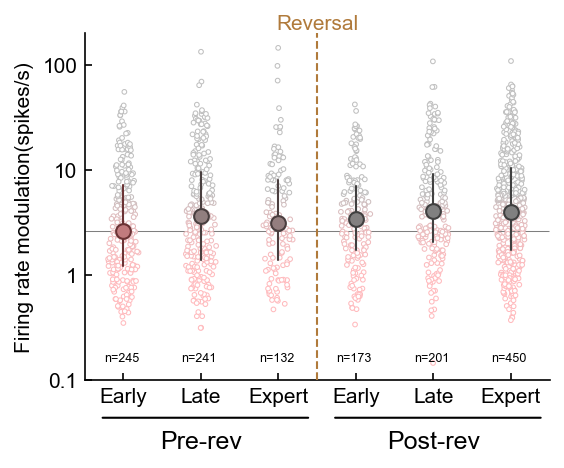

meta NOT subset; don't know how to subset; dropped


In [255]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.median(FRmod_preearly)

fig, ax = plt.subplots(figsize=(4,3))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-rev','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.5)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axhline(FRmod_baseline_median,color='k',linestyle='-',lw=0.5,zorder=-40)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pad=2.5 #in points
ax.tick_params(axis='both', which='major')
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
for idx,column in enumerate(data):
    ax.text(idx-0.25,0.15,'n='+str(len(column)),fontsize=6)
#animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

ax.annotate('', xy=(0.03, -0.11), xycoords='axes fraction', xytext=(0.49, -0.11),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.11), xycoords='axes fraction', xytext=(0.99, -0.11),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Pre-rev', xy=(0.15, -10), xycoords='axes points', xytext=(0.15, -10),color='black',fontsize=12)
# ax.annotate('Pre-rev', xy=(0.16, -0.2), xycoords='axes fraction', color='black',fontsize=12)
# ax.annotate('Post-rev', xy=(0.66, -0.2), xycoords='axes fraction', color='black',fontsize=12)

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

# get the x-position of the second tick label
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
# add the text under the second label
ax.text(xtick_pos_pre,ax.get_ylim()[0]-0.08, 'Pre-rev', ha='center', va='bottom', fontsize=12)
ax.text(xtick_pos_post,ax.get_ylim()[0]-0.08, 'Post-rev', ha='center', va='bottom', fontsize=12)

#statistics
#ax.text(1,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(2,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(3,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(4,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
#ax.text(5,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
plt.show()
fig.tight_layout()
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift FRmod over exposure V2.pdf'),transparent=False,facecolor="white")

meta NOT subset; don't know how to subset; dropped


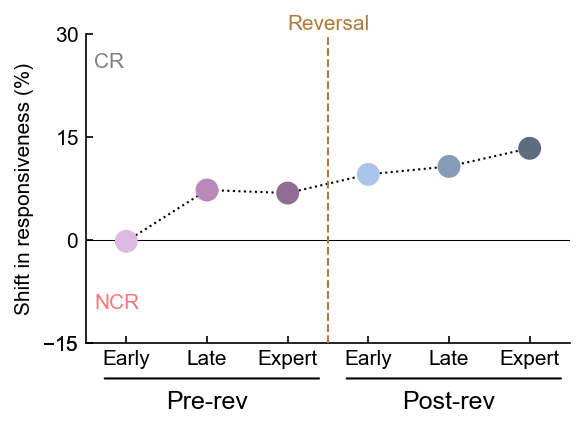

In [256]:
fig, ax = plt.subplots(figsize=(4,3))
#fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
labels = ['Early','Late','Expert','Early','Late','Expert']
#percentCR = np.array([FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
#labels = ['Pre Late','Early','Intermediate\npost-reversal','Late']
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)
#ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),c=PHASE_COLORS,s=100,zorder=10)

xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-15,30])
ax.set_yticks([-15,-15,0,15,30])

ax.text(-0.4,25,'CR',color=CR_COLOR)
ax.text(-0.4,-10,'NCR',color=NCR_COLOR)

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

#Add line
ax.annotate('', xy=(0.03, -0.115), xycoords='axes fraction', xytext=(0.49, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.115), xycoords='axes fraction', xytext=(0.99, -0.115),arrowprops=dict(arrowstyle='-', color='black'))
# get the x-position of the second tick label
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
# add the text under the second label
ax.text(xtick_pos_pre, -22, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -22, 'Post-rev', ha='center', va='top',  fontsize=12)

#ax.annotate('', xy=(0.04, -0.08), xycoords='axes fraction', xytext=(0.47, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.54, -0.08), xycoords='axes fraction', xytext=(0.97, -0.08),arrowprops=dict(arrowstyle='-', color='black'))

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

plt.tight_layout()
#fig.savefig(os.path.join('D:\\\\Figures','Tuning Figures','Passive no behavior Shift in responsiveness V2.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift in responsiveness V2.pdf'),transparent=False,facecolor="white")

(0.42097718360607495, 0.19810071782476768, 0.20786173092467894)
(0.287481233672967, 0.24571078187198975, 0.2475401447245873)
(0.29417824746592147, 0.2442955204196111, 0.24648016539974144)
(0.2568044776498045, 0.2504380590044969, 0.25071688025903593)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)
(0.25098039215686274, 0.25098039215686274, 0.25098039215686274)


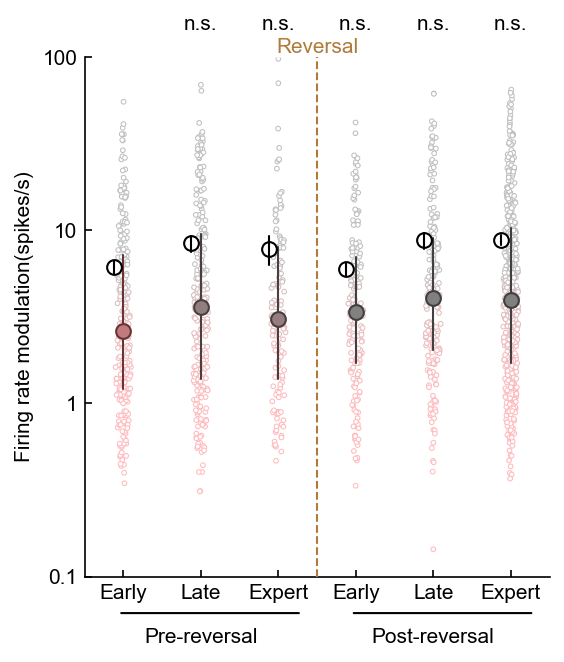

meta NOT subset; don't know how to subset; dropped


In [22]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.median(FRmod_preearly)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    ax.scatter([idx-0.125], [median], ec='k',fc='white', s=summary_size,lw=summary_width, zorder=100)
    ax.plot([idx-0.125, idx-0.125], [Q1, Q3], c='k', lw=summary_width, zorder=900, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
#
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.47, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.57, -0.07), xycoords='axes fraction', xytext=(0.97, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
ax.text(1,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
ax.text(2,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
ax.text(3,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
ax.text(4,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
ax.text(5,175,str('n.s.'),verticalalignment='top',horizontalalignment='center')
plt.show()

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift FRmod over exposure.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac folder/Figures','Passive no behavior Shift FRmod over exposure.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','Passive no behavior Shift FRmod over exposure.pdf'),transparent=False,facecolor="white")

In [23]:
#pre_early = first 3 days
#pre_late = next 3 days
#pre_expert = next 2
#post_early = next 3 days
#post_late = next 3 days
#post_expert = next 2 days

In [24]:
#preexpert_session_num

In [25]:
#len(preexpert_session_num)

In [26]:
#postexpert_session_num

In [27]:
#len(postexpert_session_num)

In [28]:
#postlate_session_num

In [29]:
#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(FRmod_preearly,FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(FRmod_prelate,FRmod_baseline_median))
FRmod_preexpert_pc = np.nanmean(np.greater(FRmod_preexpert,FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(FRmod_postearly,FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(FRmod_postlate,FRmod_baseline_median))
FRmod_postexpert_pc = np.nanmean(np.greater(FRmod_postexpert,FRmod_baseline_median))


meta NOT subset; don't know how to subset; dropped


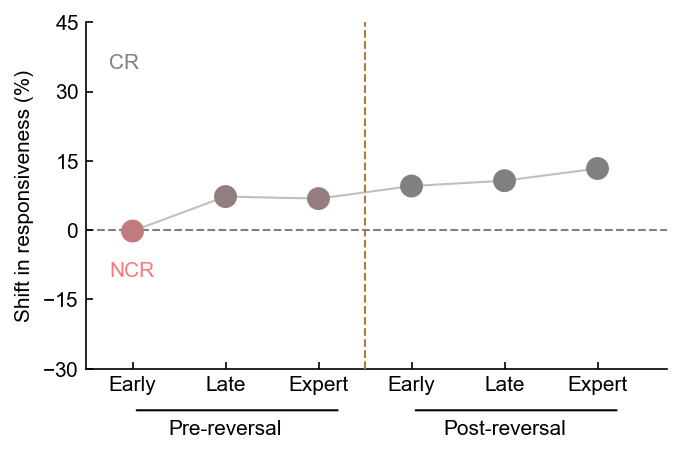

In [30]:
# shift in responsiveness graph
fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']

numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='grey',lw=1,alpha=0.5)
#ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.5,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-30,45])
ax.set_yticks([-30,-15,0,15,30, 45])
ax.text(-0.25,35,'CR',color=CR_COLOR)
ax.text(-0.25,-10,'NCR',color=NCR_COLOR)

ax.annotate('', xy=(0.08, -0.12), xycoords='axes fraction', xytext=(0.44, -0.12),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.56, -0.12), xycoords='axes fraction', xytext=(0.92, -0.12),arrowprops=dict(arrowstyle='-', color='black'))

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift in responsiveness.pdf'),transparent=False,facecolor="white")


meta NOT subset; don't know how to subset; dropped


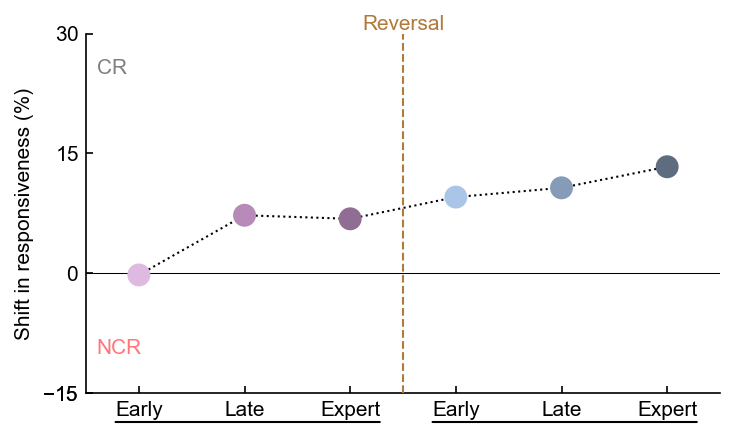

In [31]:
fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
labels = ['Early','Late','Expert','Early','Late','Expert']
#percentCR = np.array([FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
#labels = ['Pre Late','Early','Intermediate\npost-reversal','Late']
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)
#ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),c=PHASE_COLORS,s=100,zorder=10)

xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-35,25])
# ax.set_yticks([-30,-20,-10,0,10,20])
# ax.text(-0.5,20,'NCR',color=NCR_COLOR)
# ax.text(-0.5,-30,'CR',color=CR_COLOR)

#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-35,65])
#ax.set_yticks([-30,-15,0,15,30,45,60])
#ax.text(-0.5,55,'NCR',color=NCR_COLOR)
#ax.text(-0.5,-30,'CR',color=CR_COLOR)

xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-15,30])
ax.set_yticks([-15,-15,0,15,30])

ax.text(-0.4,25,'CR',color=CR_COLOR)
ax.text(-0.4,-10,'NCR',color=NCR_COLOR)

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)


ax.annotate('', xy=(0.04, -0.08), xycoords='axes fraction', xytext=(0.47, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -0.08), xycoords='axes fraction', xytext=(0.97, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

plt.tight_layout()
#fig.savefig(os.path.join('D:\\\\Figures','Tuning Figures','Passive no behavior Shift in responsiveness V2.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Figures','Passive no behavior Shift in responsiveness V2.pdf'),transparent=False,facecolor="white")


In [32]:
#Stats analysis

In [33]:
#Create a namespace containing FRmod from each learning phase

obj = SimpleNamespace(prereversal_early=FRmod_preearly,
                      prereversal_late=FRmod_prelate,
                      prereversal_expert=FRmod_preexpert,
                      postreversal_early=FRmod_postearly,
                      postreversal_late=FRmod_postlate,
                      postreversal_expert=FRmod_postexpert
                     )


In [34]:
obj

namespace(prereversal_early=array([ 1.99329983,  1.02380952,  0.67039106, 15.72864322,  8.69346734,
                                    9.56448911,  4.87437186,  1.47403685, 13.92857143,  4.7037037 ,
                                    2.8879892 ,  4.40044004,  7.03703704,  4.82905983,  4.22110553,
                                   11.52722444,  0.56022409,  6.98492462, 19.07872697,  4.72361809,
                                   16.44891122, 13.27131783,  6.29815745, 16.46090535, 17.59057971,
                                   32.93132328, 25.64489112,  1.65997323,  1.33333333, 18.10720268,
                                    1.1299435 ,  9.26298157, 33.16073355,  4.00335008,  3.60587002,
                                    2.20043573, 55.12562814, 35.79564489, 28.9279732 , 12.39530988,
                                    5.10887772,  1.30434783,  6.91792295,  2.4120603 , 16.9681742 ,
                                   15.67282322, 10.72222222,  3.18257956,  6.99415205,  0.68676717,


In [35]:
filename = 'C:\\Users\insan\\Desktop\\Passive Analysis/passiveFRmod.pickle'
with open(filename, 'wb') as f:
    pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('C:\\Users\insan\\Desktop\\Passive Analysis/passiveFRmod.pickle', "rb") as f:
    data = pickle.load(f)

In [37]:
phase = len(data.postreversal_early)*["pre-early"] + len(data.prereversal_late)*["pre-late"] + len(data.prereversal_expert)*["pre-expert"] \
        + len(data.postreversal_early)*["post-early"] + len(data.postreversal_late)*["post-late"] + len(data.postreversal_expert)*["post-expert"] 
mod = np.concatenate([data.postreversal_early, data.prereversal_late, data.prereversal_expert, data.postreversal_early, data.postreversal_late, data.postreversal_expert])

df = pd.DataFrame({"phase": phase, "FR_mod": mod})

In [38]:
# Checking that the anova is significant

pg.anova(df, dv="FR_mod", between="phase")

,Source,ddof1,ddof2,F,p-unc,np2
0,phase,5,1364,2.619006,0.022943,0.009509


In [39]:
# Pairwise Tukey-HSD post-hoc test

pairwise_tukey = pg.pairwise_tukey(data=df, dv='FR_mod', between="phase")

pairwise_tukey[pairwise_tukey["p-tukey"] <= 0.05][["A", "B", "p-tukey", "hedges"]]
#pairwise_tukey[:][["A", "B", "p-tukey", "hedges"]]

,A,B,p-tukey,hedges


In [40]:
# Conducting pairwise tests using Benjamini/Hochberg FDR correction to Mann-Whitney U

pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between="phase", padjust="fdr_bh", parametric=False, )

pairwise_mwu[pairwise_mwu["p-corr"] <= 0.05][["A", "B", "p-corr", "hedges"]]
#pairwise_mwu[:][["A", "B", "p-corr", "hedges"]]

,A,B,p-corr,hedges


In [41]:
ACsessionfile.meta.files

['February 24 2023 Passive Go No-go TH_234_4001']

In [42]:
ACsessionfile.meta

namespace(directory='D:\\DualRecording\\TH_234\\TH_234 4\\AC\\',
          region='AC',
          animal='TH_234',
          probe=11419,
          date='02/24/2023',
          depth=1284,
          task='passive no behavior',
          day_of_training=8,
          day_of_recording=4,
          first_tuning_trial=-1,
          length_in_samples=59718916.0,
          files=['February 24 2023 Passive Go No-go TH_234_4001'],
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=1990.6305333333332,
          length_in_minutes=33.17717555555556,
          length_in_trials=398,
          first_tuning_trial_corrected=398)

In [43]:
ACsessionfile.clusters.good

array([ 26,  28,  30,  60,  63,  73,  91,  97, 110], dtype=int64)

In [44]:
sessionfile.responsiveness[2]['all_trials'].FRmodulation

KeyError: 2

In [ ]:
animalnames = np.concatenate([cohort1,cohort2,cohort3])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    

In [ ]:
#sessionfile.responsiveness[2]['all_trials']
sessionfile.responsiveness[2]['all_trials'].FRmodulation

In [ ]:
sessionfile.clusters.good

In [ ]:
clust_good = sessionfile.clusters.good

In [ ]:
type(sessionfile)

In [ ]:
#sessionfile.responsiveness

In [ ]:
FRmod = []
for i in range(len(clust_good)):
    FRmod.append(sessionfile.responsiveness[clust_good[i]]['all_trials'].FRmodulation)
    
print(FRmod)

In [ ]:
sessionfile.responsiveness[2]